In [105]:
def load_data():
    """
    Load data from sc-est2017-agesex-civ.csv
    """
    import csv

    with open('sc-est2017-agesex-civ.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)

        # 999 means total of all age group
        census = list(filter(lambda x: x['NAME'] != 'United States' and
                             x['AGE'] != '999' and
                             x['AGE'] != '85',
                             reader))
        return census

def population_by_year(year=2010, census=None):
    """
    Filters through census dataset and returns the list by year of data
    """

    if census is None:
        return None

    key = 'POPEST{}_CIV'.format(year)

    states = {}

    for row in census:
        state = row['STATE']

        if state not in states:
            states[state] = {'Name': row['NAME'], 'id': int(row['STATE']), 'Population': 0}

        states[state]['Population'] += int(row[key])

    return list(states.values())

def filter_state(year, state, census=None):
    """
    Filters through the census data by year and state
    """
    if census is None:
        return None

    key = 'POPEST{}_CIV'.format(year)

#     for row in d
    
    data = list(filter(lambda x: str(x['STATE']) == str(state) and
                       int(x['AGE']) != 999 and 
                       x['SEX'] != '0', census))

#     print(data)
#     for row in data:
#         print(row['SEX'])
    
#     age = {}

#     for row in data:

#         if row['AGE'] not in age:
#             age[row['AGE']] = {'Age': int(row['AGE']), 'Population': 0, 'Gender': row['SEX']}
#         age[row['AGE']]['Population'] += int(row[key])

    res = []
    
    for row in data:
        res.append({
            'Age': int(row['AGE']),
            'Population': int(row[key]),
            'Gender': 'Male' if int(row['SEX']) == 1 else 'Female'
        })
        
    return res

def show_map(census, year):
    """
    Create interactive US map that shows the map that you can click
    and show a more detailed dataset
    """
    import altair as alt
    from vega_datasets import data

    states = alt.topo_feature(data.us_10m.url, 'states')

    click = alt.selection(type='single', on='click', fields=['id'])

    # US states background
    background = alt.Chart(
        states
    ).encode(
        color=alt.condition(click,
                            alt.Color('Population', type='quantitative'),
                            alt.value('lightgray')),
        tooltip=['Population:Q', 'Name:N']
    ).mark_geoshape(
        fill='lightgray',
        stroke='black'
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(alt.Data(values=census), 'id', ['Population', 'Name'])
    ).properties(
        title='US Census of {}'.format(year),
        width=1000,
        height=400
    ).project(
        type='albersUsa'
    ).add_selection(
        click
    )

    return background

def show_bar(census):
    """
    Create a bar chart that shows the age group of the specific state
    """

    import altair as alt

    bars = alt.Chart(alt.Data(values=census)).mark_bar().encode(
        x='Population:Q',
        y=alt.Y(
            'Age:N',
        ),
        color=alt.Color('Population:Q')
    )

    return bars

def show_scatter(data, state, year):
    """
    Create a scatter plot that shows the age group of the specific state
    """
    import altair as alt
    
#     print(filter_state(year, state, data))

    source = alt.Data(values=filter_state(year, state, data))

    brush = alt.selection_interval(encodings=['x'])

    scatter = alt.Chart(source).mark_point().encode(
        x='Age:Q',
        y='Population:Q',
        tooltip=['Age:Q', 'Population:Q'],
        color=alt.condition(brush, 'Age:N', alt.value('lightgray'), legend=None)
    ).transform_aggregate(
        Population='sum(Population)',
        groupby=['Age']
    ).properties(
        width=500,
        height=500,
        title='Scatter Plot of {}'.format(state_name)
    ).add_selection(
        brush
    )

    age_bars = alt.Chart(source).mark_bar().encode(
        x='Population:Q',
        y=alt.Y(
            'Age:N',
            sort=alt.EncodingSortField(
                field="Population", # The field to use for the sort
                op="max", # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        tooltip=['Population:Q']
    ).properties(
        title='Top 50 Within Highlighted Range',
        width=300,
        height=500
    ).transform_aggregate(
        Population='sum(Population)',
        groupby=['Age']
    ).transform_filter(
        brush
    ).transform_window(
        window=[{'op': 'rank', 'as': 'rank'}],
        sort=[{'field': 'Population', 'order': 'descending'}]
    ).transform_filter('datum.rank <= 50')
    
    gender_bars = alt.Chart(source).mark_bar().encode(
        x='Gender:N',
        y='Population:Q',
        tooltip=['Population:Q', 'Gender:N']
    ).transform_filter(
        brush
    ).transform_aggregate(
        Population='sum(Population)',
        groupby=['Gender']
    ).properties(
        title='Age Group by Gender',
        width=200,
        height=500
    )
    
    return alt.hconcat(scatter, age_bars, gender_bars)

def state_name(data, state):

    for row in data:
        if row['STATE'] == state:
            return row['NAME']

    return None


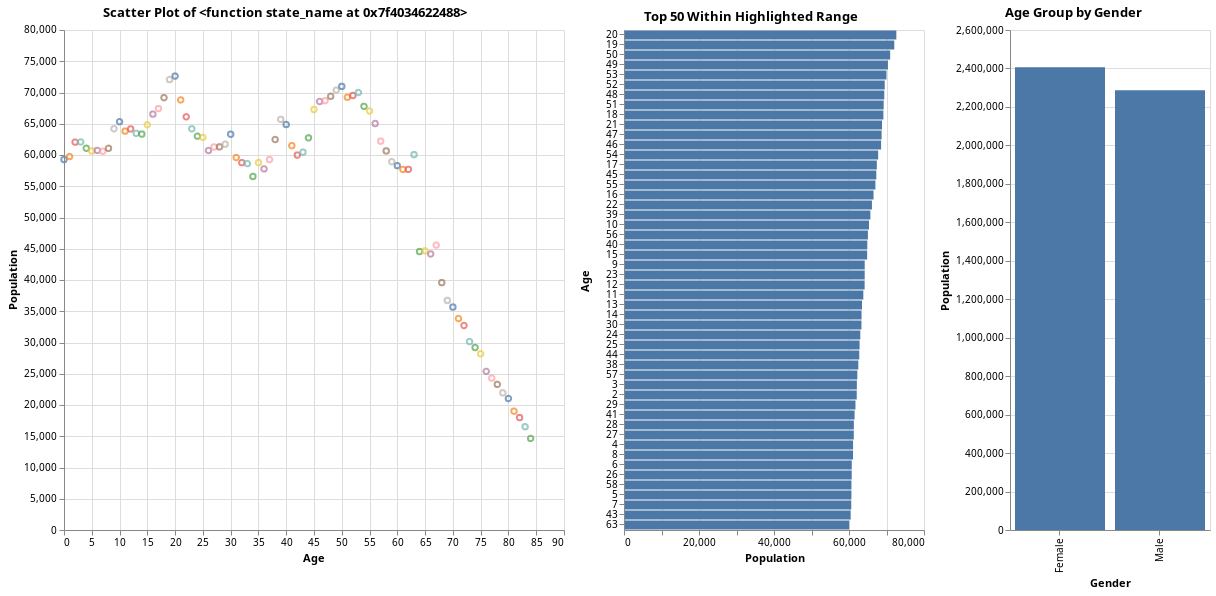

In [106]:
data = load_data()
# show_scatter(filter_state(2010, 1, data), state_name(data, 1))
show_scatter(data=data, year=2010, state=1)